In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
image = cv2.imread("lena.jpeg", 0)
image2 = cv2.imread("edge.jpg", 0)

# Edge Detection

In [3]:
def edge_detection(image):
    
    rows, cols = image.shape
   
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    prewitt_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    prewitt_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
    
    robert_x = np.array([[1, 0], [0, -1]])
    robert_y = np.array([[0, 1], [-1, 0]])
    
    laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    
    methods = {
        'Sobel': (sobel_x, sobel_y),
        'Prewitt': (prewitt_x, prewitt_y),
        'Robert': (robert_x, robert_y),
        'LoG': (laplacian, None)
    }
    
    results = {}
    
    for method, (kernel_x, kernel_y) in methods.items():
        gradient_x = np.zeros_like(image, dtype=np.float32)
        gradient_y = np.zeros_like(image, dtype=np.float32) if kernel_y is not None else None
        
        for i in range(1, rows-1):
            for j in range(1, cols-1):
                if method in ['Sobel', 'Prewitt', 'LoG']:
                    gradient_x[i, j] = np.sum(kernel_x * image[i-1:i+2, j-1:j+2])
                    if kernel_y is not None:
                        gradient_y[i, j] = np.sum(kernel_y * image[i-1:i+2, j-1:j+2])
                elif method == 'Robert':
                    gradient_x[i, j] = np.sum(kernel_x * image[i:i+2, j:j+2])
                    gradient_y[i, j] = np.sum(kernel_y * image[i:i+2, j:j+2])
        
        if kernel_y is not None:
            gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
        else:
            gradient_magnitude = np.abs(gradient_x)
        
        gradient_magnitude = (gradient_magnitude - gradient_magnitude.min()) / (gradient_magnitude.max() - gradient_magnitude.min()) * 255
        results[method] = gradient_magnitude.astype(np.uint8)
    
    weak, strong = 50, 150
    canny_edges = np.zeros_like(image)
    strong_edges = results['Sobel'] > strong
    weak_edges = (results['Sobel'] >= weak) & (results['Sobel'] <= strong)
    canny_edges[strong_edges] = 255
    canny_edges[weak_edges] = 100
    results['Canny'] = canny_edges

    plt.figure(figsize=(18, 6))
    for i, (method, result) in enumerate(results.items(), 1):
        plt.subplot(2, 5, i)
        plt.imshow(result, cmap='gray')
        plt.title(f'{method} Edge Detection')
        plt.axis('off')
        plt.subplot(2,5,i+5)
        plt.imshow(result-255, cmap='gray')
        plt.title(f' {method} Edge Detection Negative')
        plt.axis('off')
    
    plt.show()

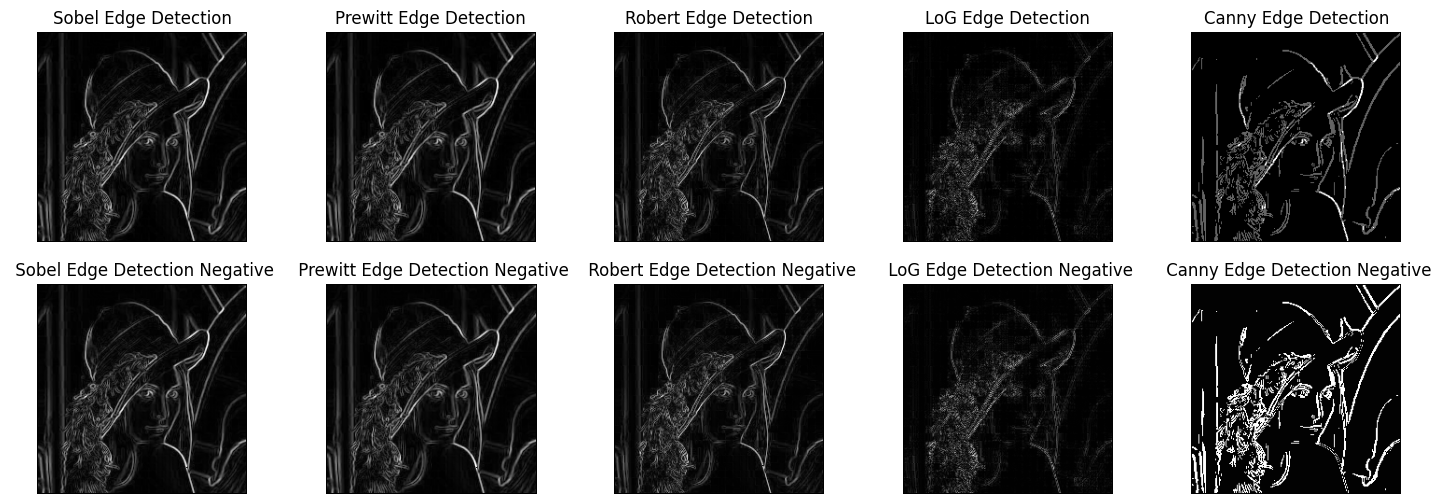

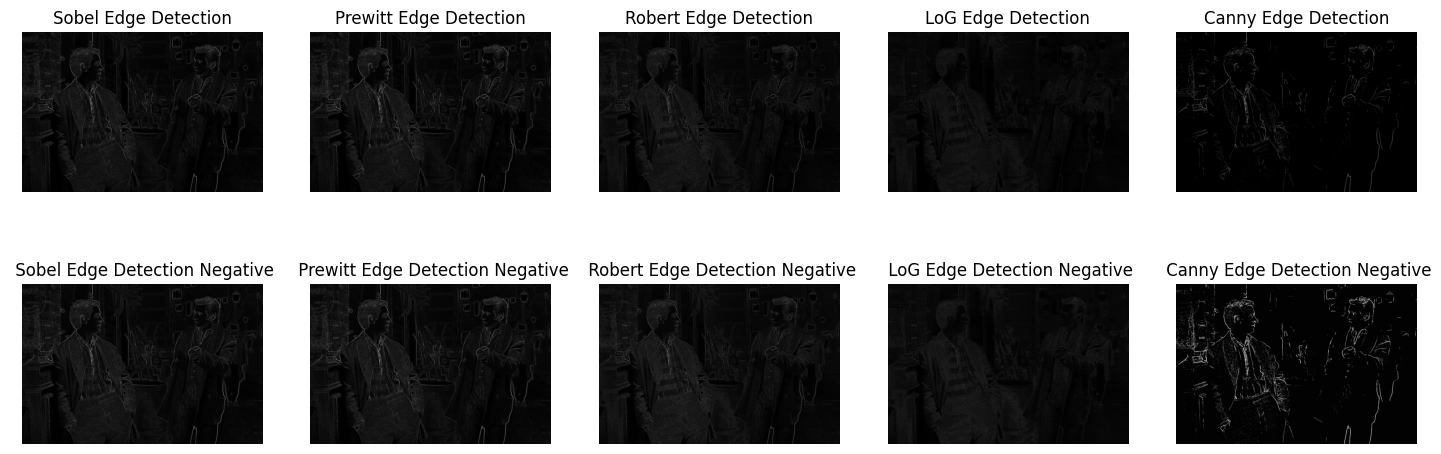

In [4]:
edge_detection(image)
edge_detection(image2)

# Noise Addition

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def noise_addition(image, nv=25, sp_ratio=0.02, quant_levels=10, impulse_ratio=0.02):
    """
    Add Gaussian, Salt & Pepper, Quantization, and Impulse noise to an image and display them with histograms.
    
    Parameters:
        image (numpy array): Input image.
        nv (int): Noise variance for Gaussian noise.
        sp_ratio (float): Ratio of pixels affected by salt and pepper noise.
        quant_levels (int): Number of quantization levels.
        impulse_ratio (float): Ratio of pixels affected by impulse noise.
    """
    # Convert image to grayscale if it is colored
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    
    images = {"Original Color": image, "Original Gray": gray_image}
    noises = {}
    
    # Gaussian Noise
    gaussian_noise = np.random.normal(0, nv, image.shape)
    noises["Gaussian Color"] = np.clip(image + gaussian_noise, 0, 255).astype(np.uint8)
    noises["Gaussian Gray"] = np.clip(gray_image + gaussian_noise[..., 0], 0, 255).astype(np.uint8)
    
    # Salt & Pepper Noise
    salt_pepper = np.random.rand(*gray_image.shape)
    sp_color = np.copy(image)
    sp_gray = np.copy(gray_image)
    sp_color[salt_pepper < sp_ratio/2] = 0
    sp_color[salt_pepper > 1 - sp_ratio/2] = 255
    sp_gray[salt_pepper < sp_ratio/2] = 0
    sp_gray[salt_pepper > 1 - sp_ratio/2] = 255
    noises["Salt & Pepper Color"] = sp_color
    noises["Salt & Pepper Gray"] = sp_gray
    
    # Quantization Noise
    noises["Quantization Color"] = (image // (256 // quant_levels)) * (256 // quant_levels)
    noises["Quantization Gray"] = (gray_image // (256 // quant_levels)) * (256 // quant_levels)
    
    # Impulse Noise
    impulse_noise = np.random.rand(*gray_image.shape)
    impulse_color = np.copy(image)
    impulse_gray = np.copy(gray_image)
    impulse_color[impulse_noise < impulse_ratio/2] = 0
    impulse_color[impulse_noise > 1 - impulse_ratio/2] = 255
    impulse_gray[impulse_noise < impulse_ratio/2] = 0
    impulse_gray[impulse_noise > 1 - impulse_ratio/2] = 255
    noises["Impulse Color"] = impulse_color
    noises["Impulse Gray"] = impulse_gray
    
    images.update(noises)
    
    # Display Original and Noised Images with Histograms
    fig, axs = plt.subplots(len(images), 2, figsize=(12, len(images) * 3))
    
    for i, (noise_type, img) in enumerate(images.items()):
        cmap = None if len(img.shape) == 3 else 'gray'
        axs[i, 0].imshow(img, cmap=cmap)
        axs[i, 0].set_title(f"{noise_type} Image")
        axs[i, 0].axis("off")
        axs[i, 1].hist(img.ravel(), bins=256, range=[0, 256], color='gray', alpha=0.7)
        axs[i, 1].set_title(f"Histogram of {noise_type} Image")
    
    plt.tight_layout()
    plt.show()

    return noises["Gaussian Color"]

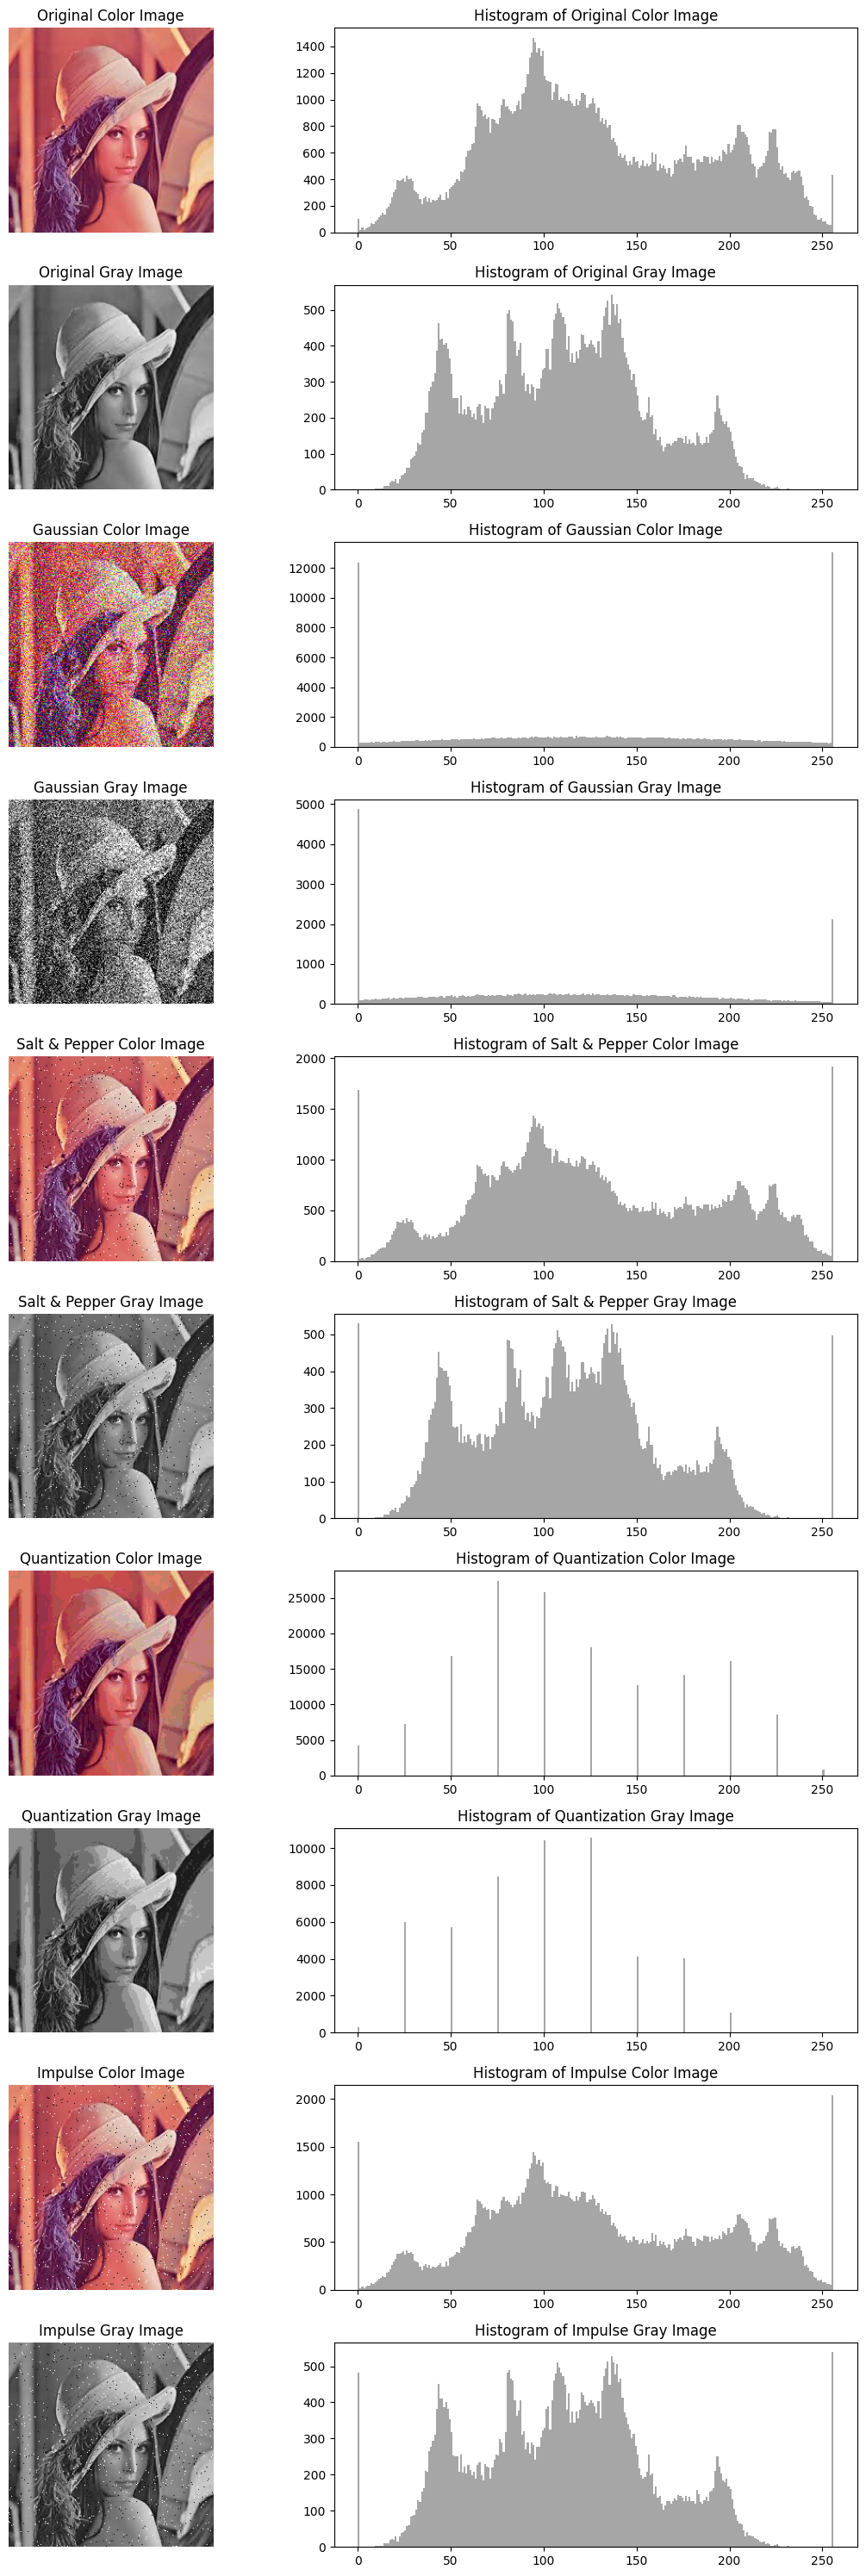

In [79]:
image = cv2.imread('lena.jpeg', 1)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
noisy_image = noise_addition(image,70)

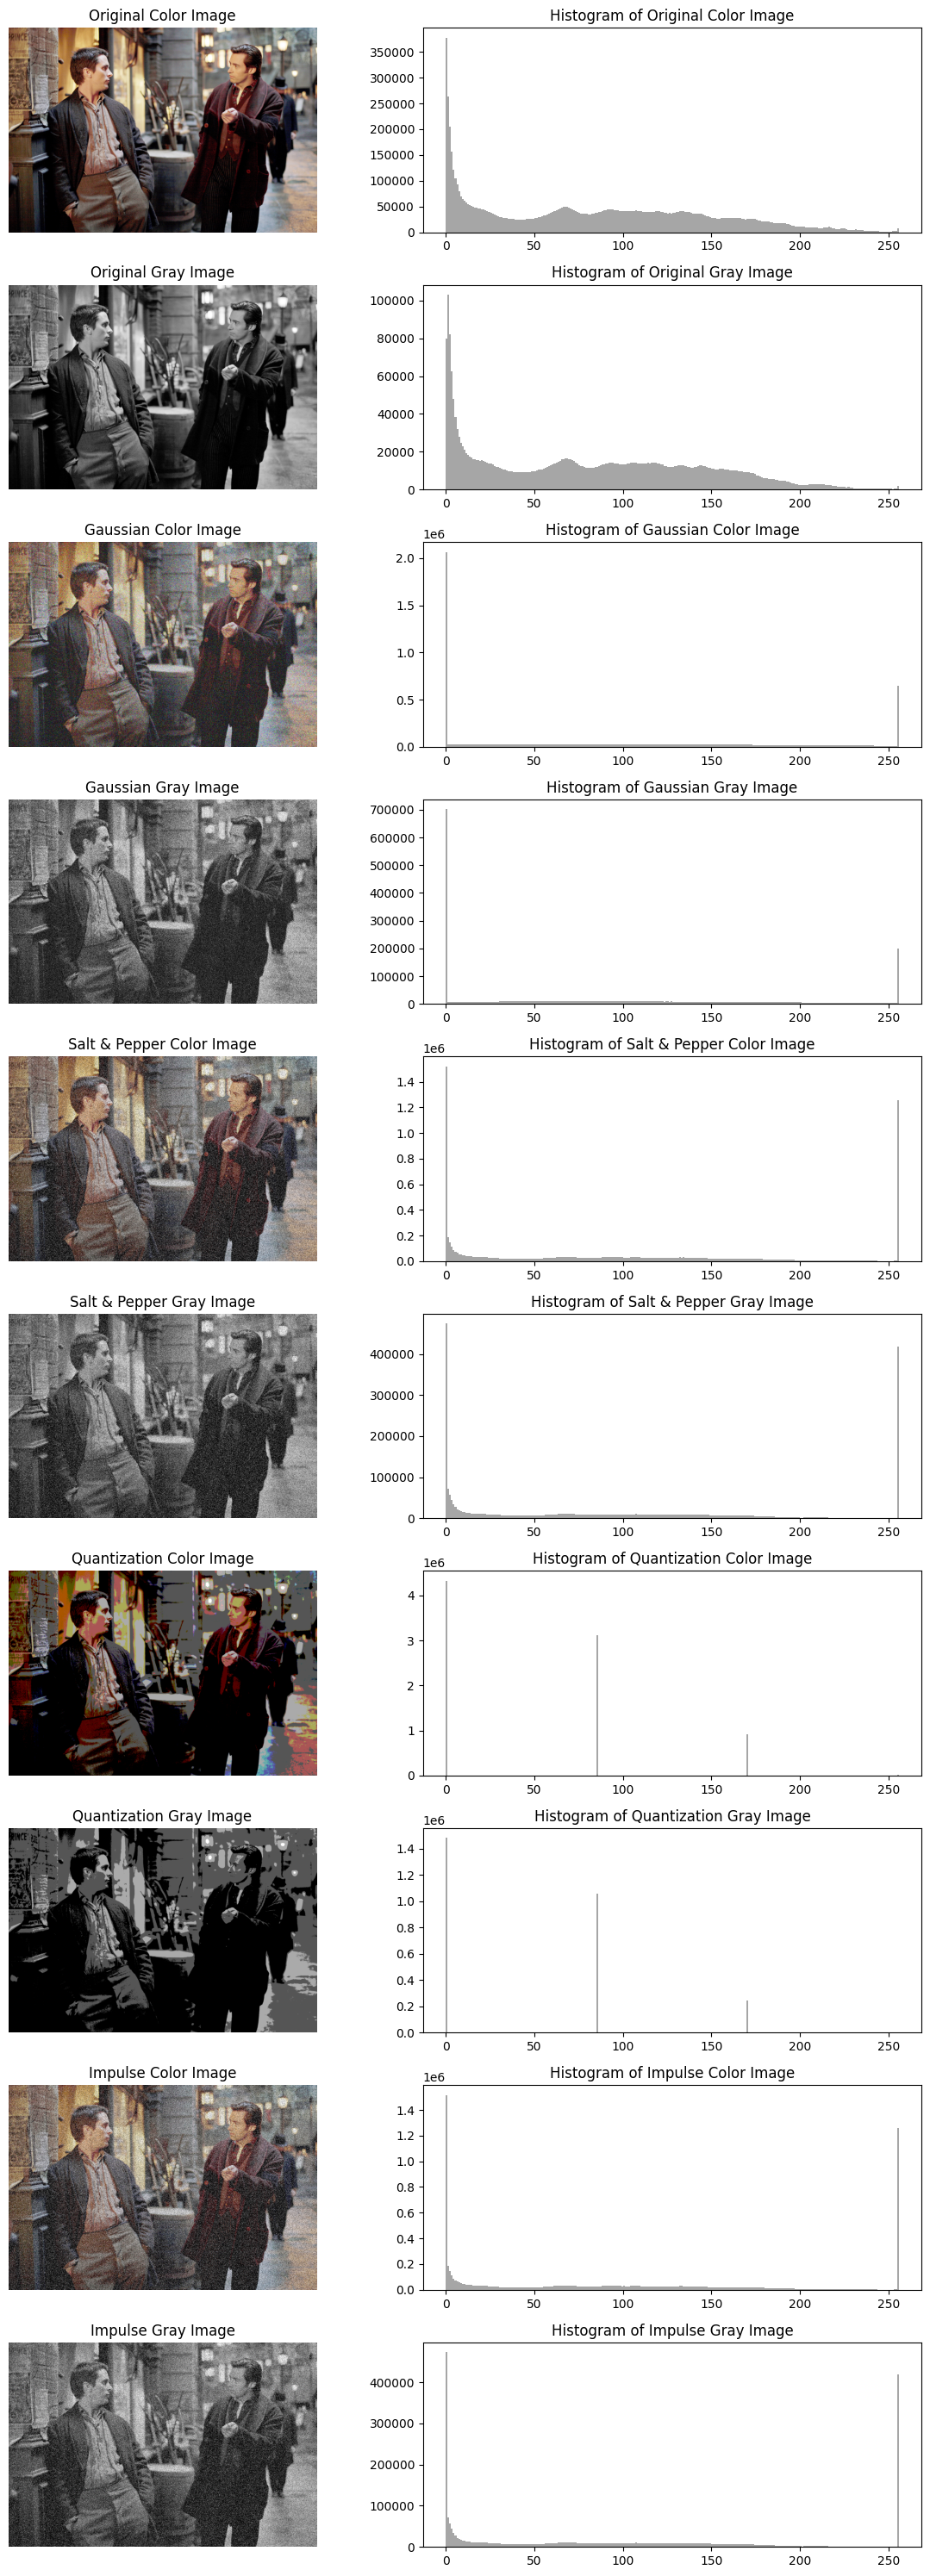

In [80]:
image2 = cv2.imread("edge.jpg", 1)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
nimage = noise_addition(image2, nv=100, sp_ratio=0.3, quant_levels=3, impulse_ratio=0.3)

# Noise Removal

In [88]:
def custom_gaussian_blur(image, kernel_size=5, sigma=1.0):
    kernel = cv2.getGaussianKernel(kernel_size, sigma)
    kernel = np.outer(kernel, kernel)
    return cv2.filter2D(image, -1, kernel)

def custom_median_blur(image, kernel_size=5):
    padded_image = np.pad(image, kernel_size // 2, mode='edge')
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            output[i, j] = np.median(padded_image[i:i+kernel_size, j:j+kernel_size])
    return output

def custom_bilateral_filter(image, d=9, sigma_color=75, sigma_space=75):
    filtered_image = np.copy(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            neighborhood = image[max(0, i-d//2):min(image.shape[0], i+d//2+1),
                                 max(0, j-d//2):min(image.shape[1], j+d//2+1)]
            color_weights = np.exp(-((neighborhood - image[i, j])**2) / (2 * sigma_color**2))
            space_weights = np.exp(-((np.arange(neighborhood.shape[0])[:, None] - d//2)**2 + 
                                     (np.arange(neighborhood.shape[1])[None, :] - d//2)**2) / (2 * sigma_space**2))
            weights = color_weights * space_weights[..., np.newaxis]
            weights /= np.sum(weights)
            filtered_image[i, j] = np.sum(neighborhood * weights)
    return filtered_image

def remove_all_noises(image):
    
    denoised_methods = {
        "Custom Gaussian Blur": custom_gaussian_blur(image),
        "Custom Median Blur": custom_median_blur(image),
        "Custom Bilateral Filter": custom_bilateral_filter(image)
    }
    
    fig, axs = plt.subplots(len(denoised_methods) + 1, 2, figsize=(12, (len(denoised_methods) + 1) * 3))
    
    axs[0, 0].imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    axs[0, 0].set_title("Original Noisy Image")
    axs[0, 0].axis("off")
    axs[0, 1].hist(image.ravel(), bins=256, range=[0, 256], color='gray', alpha=0.7)
    axs[0, 1].set_title("Histogram of Original Noisy Image")
    
    for i, (method, denoised) in enumerate(denoised_methods.items(), 1):
        cmap = 'gray' if len(denoised.shape) == 2 else None
        axs[i, 0].imshow(denoised, cmap=cmap)
        axs[i, 0].set_title(f"{method}")
        axs[i, 0].axis("off")
        axs[i, 1].hist(denoised.ravel(), bins=256, range=[0, 256], color='gray', alpha=0.7)
        axs[i, 1].set_title(f"Histogram of {method}")
    
    plt.tight_layout()
    plt.show()

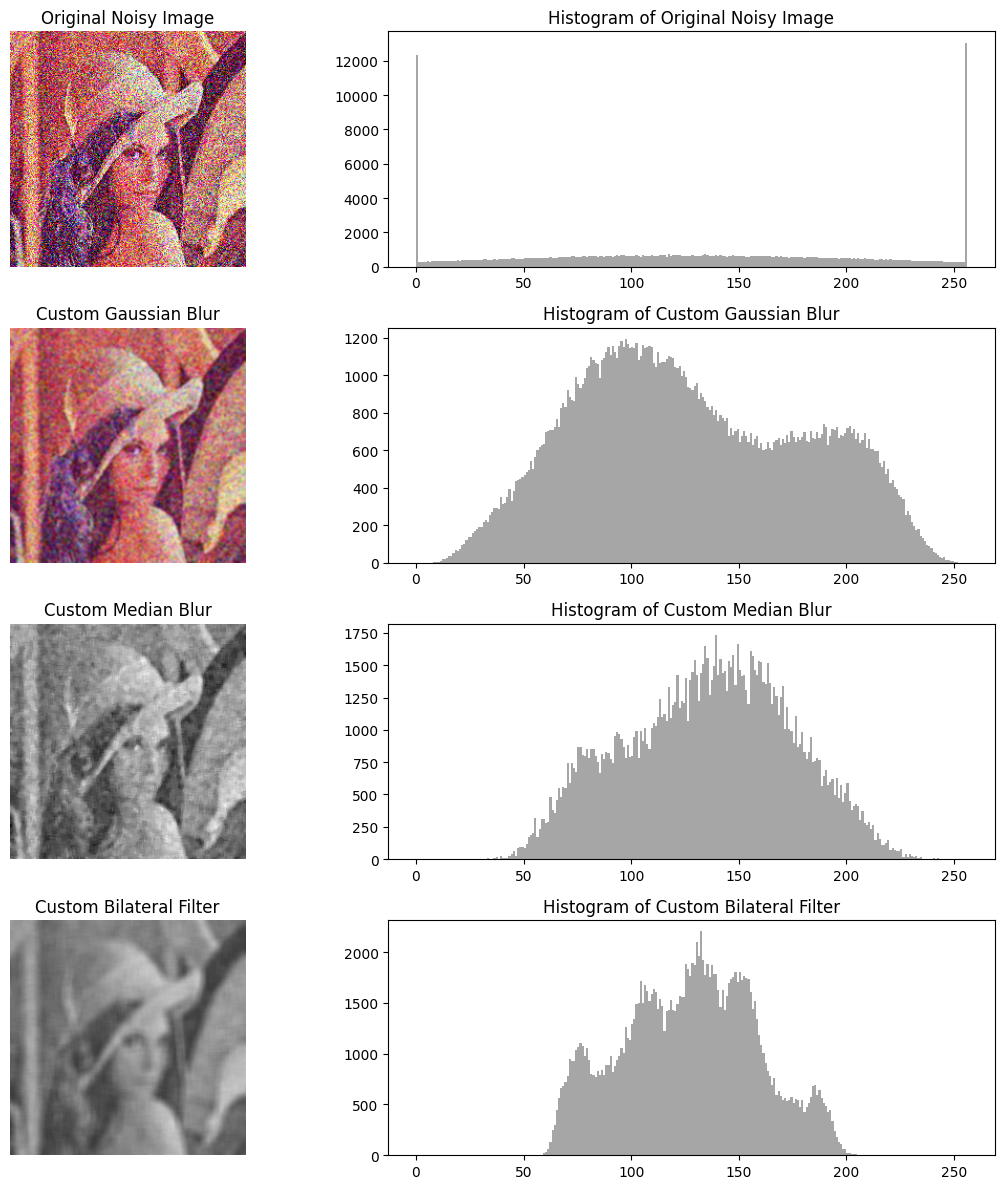

In [89]:
remove_all_noises(noisy_image)

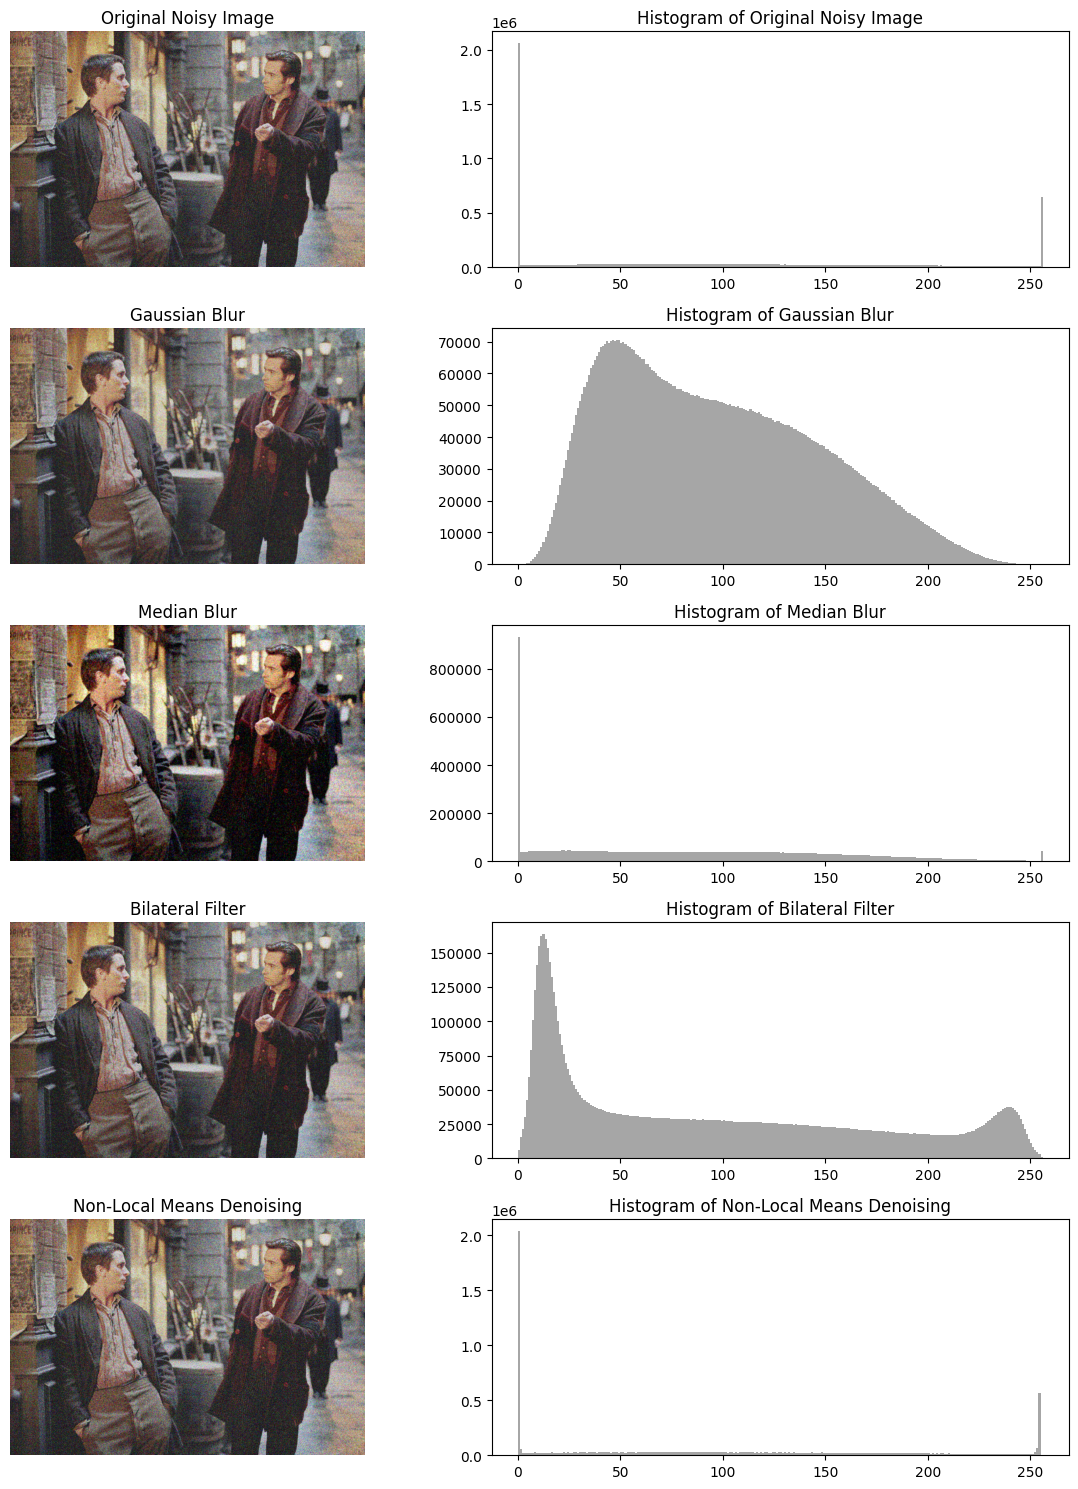

In [83]:
remove_all_noises(nimage)